In [1]:
import sys
sys.path.append('../irregular_object_packing/')

import trimesh
from pyvista import PolyData, Plotter
import numpy as np
from irregular_object_packing.mesh.transform import scale_and_center_mesh, scale_to_volume
from irregular_object_packing.mesh.utils import print_mesh_info
from irregular_object_packing.packing import initialize, nlc_optimisation as nlc, chordal_axis_transform as cat
from irregular_object_packing.packing.growth_based_optimisation import SimSettings, Optimizer
from irregular_object_packing.packing.plots import generate_tinted_colors
from importlib import reload

In [2]:
DATA_FOLDER = "../data/mesh/"

mesh_volume = 0.5
container_volume = 10

loaded_mesh = trimesh.load_mesh(DATA_FOLDER + "RBC_normal.stl")
container = trimesh.primitives.Cylinder(radius=1, height=2)

# Scale the mesh and container to the desired volume
container = scale_to_volume(container, container_volume)
original_mesh = scale_and_center_mesh(loaded_mesh, mesh_volume)

settings = SimSettings(
    itn_max=1,
    n_scaling_steps=1,
    final_scale=0.3,
    sample_rate=100,
    r=0.3
    # plot_intermediate=True,
)
optimizer = Optimizer(original_mesh, container, settings)

## Optimisation Algorithm
The next cell will execute the packing algorithm by calling `optimizer.run()`. This will perform some initial setup based on the settings, it will generate the initial positions and rotations of the objects and it will start the optimisation algorithm. depending on the settings, this can take some time. 

The optimisation works as follows:

First, the scaling barrier values are determined. These are the limits to which scale the objects can grow in each step (Described in 4.2.2 and Algorithm 1 in the paper). The scaling_barrier values are determined by the `n_scaling_steps` and the `final_scale` parameter. The default value is 0.1, which means that the objects can grow by 10% in each scaling step.


Then for each scaling step, the following itteration is performed `itn_max` times:

*The code can be found here: [irregular-object-packing/packing/growth_based_optimisation.py](../irregular_object_packing/packing/growth_based_optimisation.py)*
```Python

for i in range(self.settings.itn_max):
"""Perform a single iteration of the optimisation"""
    # DOWN SAMPLE MESHES
    container_points = trimesh.sample.sample_surface_even(self.container, self.container_sample_rate())[0]
    sample_points = trimesh.sample.sample_surface_even(self.shape, self.mesh_sample_rate())[0]

    # TRANSFORM MESHES TO OBJECT COORDINATES, SCALE, ROTATION
    obj_points = [
        trimesh.transform_points(sample_points.copy(), nlc.construct_transform_matrix(transform_data))
        for transform_data in self.tf_arrs
    ]

    # COMPUTE CAT CELLS
    self.cat_data = cat.compute_cat_cells(obj_points, container_points, self.object_coords)

    # GROWTH-BASED OPTIMISATION
    for obj_i, transform_data_i in enumerate(self.tf_arrs):
        self.local_optimisation(obj_i, self.cat_data, transform_data_i, scaling_barrier)
```


The `local_optimisation` function is the core of the optimisation algorithm. It performs the following steps:
1. compute the new optimal transform using the non-linear constraint optimisation based on a local coordinate system
2. update the transformation based on the new optimal transform. 
3. setting the new object coordinates.


In [3]:
optimizer.run()

Skipped 52 points for total of 6 points


scaling 	:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration	:   0%|          | 0/1 [00:00<?, ?it/s]

2023-03-22 20:36:20.368 (   1.208s) [          A98C98]      vtkDelaunay3D.cxx:519   WARN| vtkDelaunay3D (0x1587f6ef0): 334 degenerate triangles encountered, mesh quality suspect
/opt/homebrew/anaconda3/envs/taichi310/lib/python3.10/site-packages/pyvista/core/dataset.py:2668: PyVistaDeprecationWarning: `cell_points` is deprecated. Use `cell[i].points` instead
  warnings.warn(
/opt/homebrew/anaconda3/envs/taichi310/lib/python3.10/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


! collision found for 1 objectts with total of 1 contacts
! collision found for 1 objectts with total of 1 contacts


## Visualisation 
The following cell shows a visualisation of the final result.

/opt/homebrew/anaconda3/envs/taichi310/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


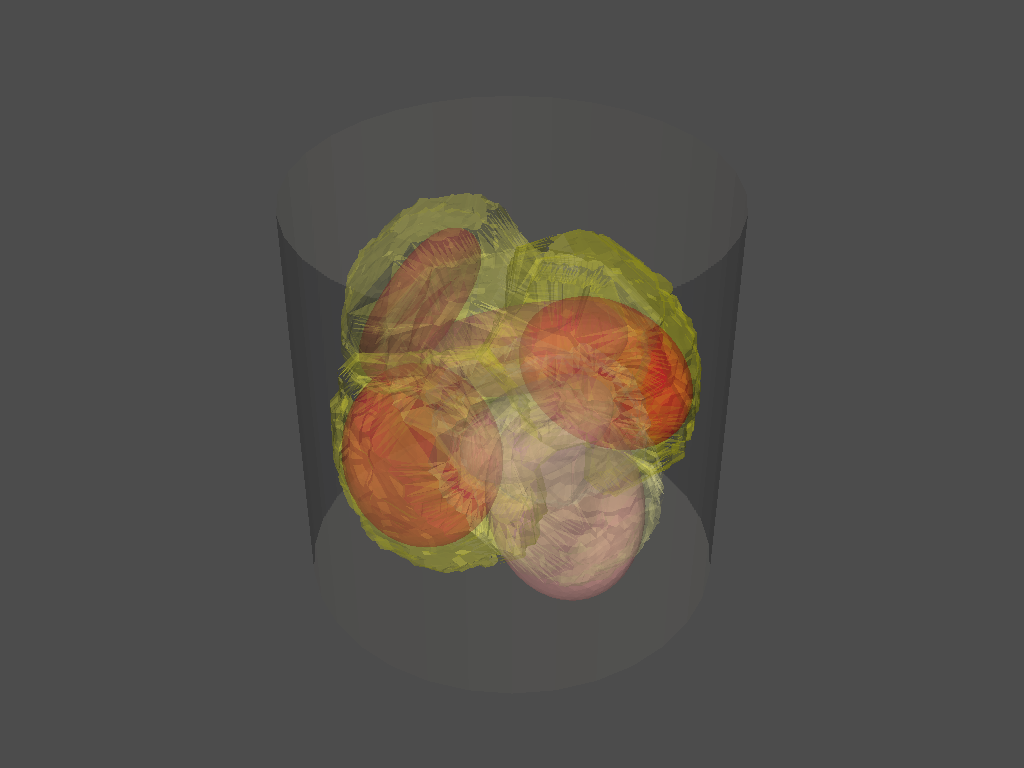

In [4]:
plotter = Plotter()
tints = generate_tinted_colors(optimizer.n_objs)

for i, mesh in enumerate(optimizer.final_meshes_after(optimizer.pv_shape)):
    plotter.add_mesh(mesh, color=tints[1][i], opacity=0.8)

for i, mesh in enumerate(optimizer.final_cat_meshes()):
    plotter.add_mesh(mesh, color=tints[0][i], opacity=0.5)

plotter.add_mesh(optimizer.container.to_mesh(), color="grey", opacity=0.3)
# plotter.add_mesh(optimizer.container, color="grey", opacity=0.2)

plotter.show(
    interactive=False,
)

/opt/homebrew/anaconda3/envs/taichi310/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


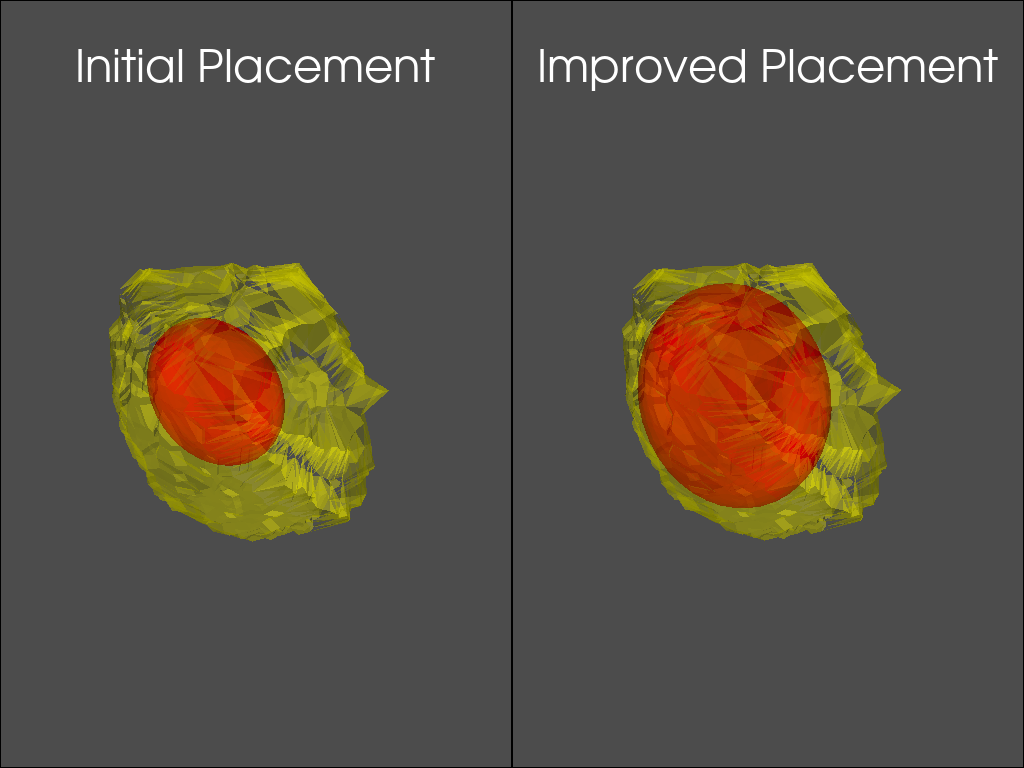

In [8]:
import irregular_object_packing.packing.plots as plots
from importlib import reload
reload(plots)
object_id = 1
iteration = 0
second = 1

# cat_cell_mesh_1 = cat.cat_mesh_from_data(optimizer.cat_log[second], object_id)



plots.plot_step_comparison(
    optimizer.mesh_before(iteration, object_id, optimizer.pv_shape),
    optimizer.mesh_after(iteration, object_id, optimizer.pv_shape),
    optimizer.cat_mesh(iteration, object_id),
)


/opt/homebrew/anaconda3/envs/taichi310/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


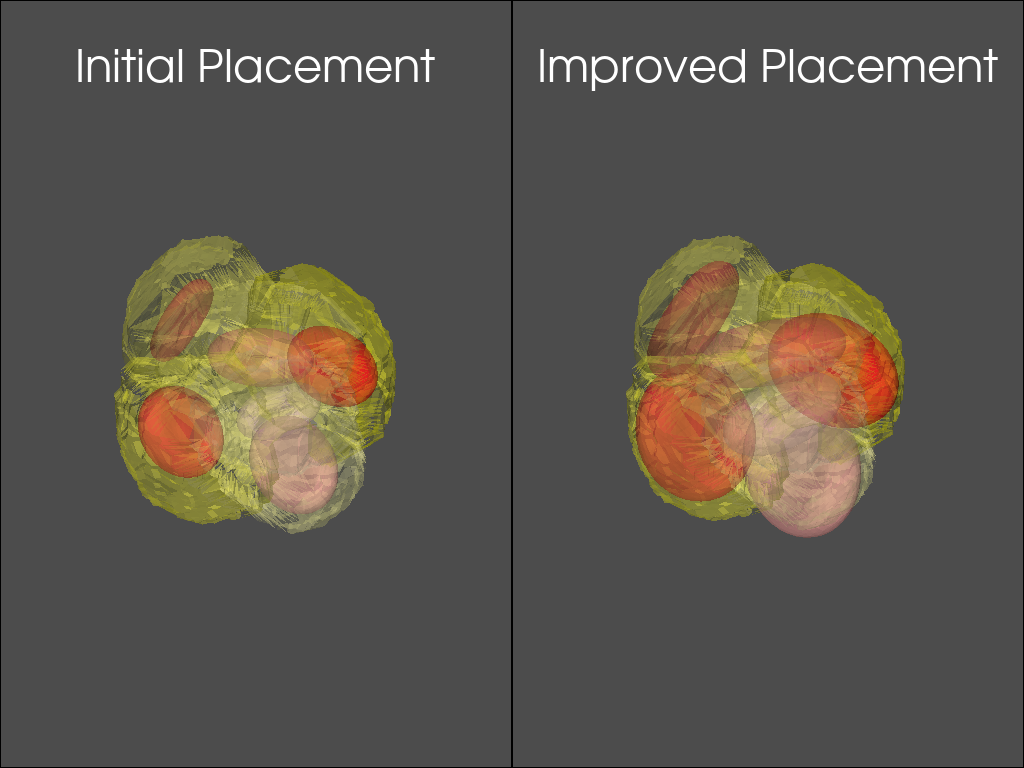

In [9]:
# Plotting the final step before and after optimization
plots.plot_full_comparison(
    optimizer.final_meshes_before(optimizer.pv_shape),
    optimizer.final_meshes_after(optimizer.pv_shape),
    optimizer.final_cat_meshes(),
)